In [1]:
from __future__ import division, print_function

import sys
path = "/Users/adrian/projects/ophiuchus/build/lib.macosx-10.5-x86_64-2.7/"
if path not in sys.path:
    sys.path.append(path)
    
# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline

# Custom
import gary.dynamics as gd
import gary.coordinates as gc
import gary.integrate as gi
import gary.potential as gp
from gary.observation import distance
from gary.units import galactic

import ophiuchus.potential as op

In [2]:
barred_mw = gp.load("/Users/adrian/projects/ophiuchus/potentials/barred_mw.yml", module=op)
static_mw = gp.load("/Users/adrian/projects/ophiuchus/potentials/static_mw.yml", module=op)

In [3]:
nsamples = 1024
np.random.seed(42)

# Position

In [4]:
d = distance(np.random.normal(14.57, 0.05, size=nsamples))
l = np.ones(d.size) * 4.8 * u.deg
b = np.ones(d.size) * 31.5 * u.deg

In [5]:
pos = coord.SkyCoord(l=l, b=b, distance=d, frame='galactic')
gc_pos = pos.transform_to(coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0.*u.pc))

In [6]:
gc_cyl = gc_pos.represent_as(coord.CylindricalRepresentation)
xyz = gc_pos.represent_as(coord.CartesianRepresentation).xyz.T.decompose(galactic).value

R,z = np.median(gc_cyl.rho), np.median(gc_cyl.z)
print("Galactocentric (R,z) = ({0:.2f}, {1:.2f}) kpc".format(R.to(u.kpc).value,z.to(u.kpc).value))
print("Heliocentric d = {0:.2f} kpc".format(np.median(pos.distance).to(u.kpc).value))

Galactocentric (R,z) = (1.18, 4.29) kpc
Heliocentric d = 8.21 kpc


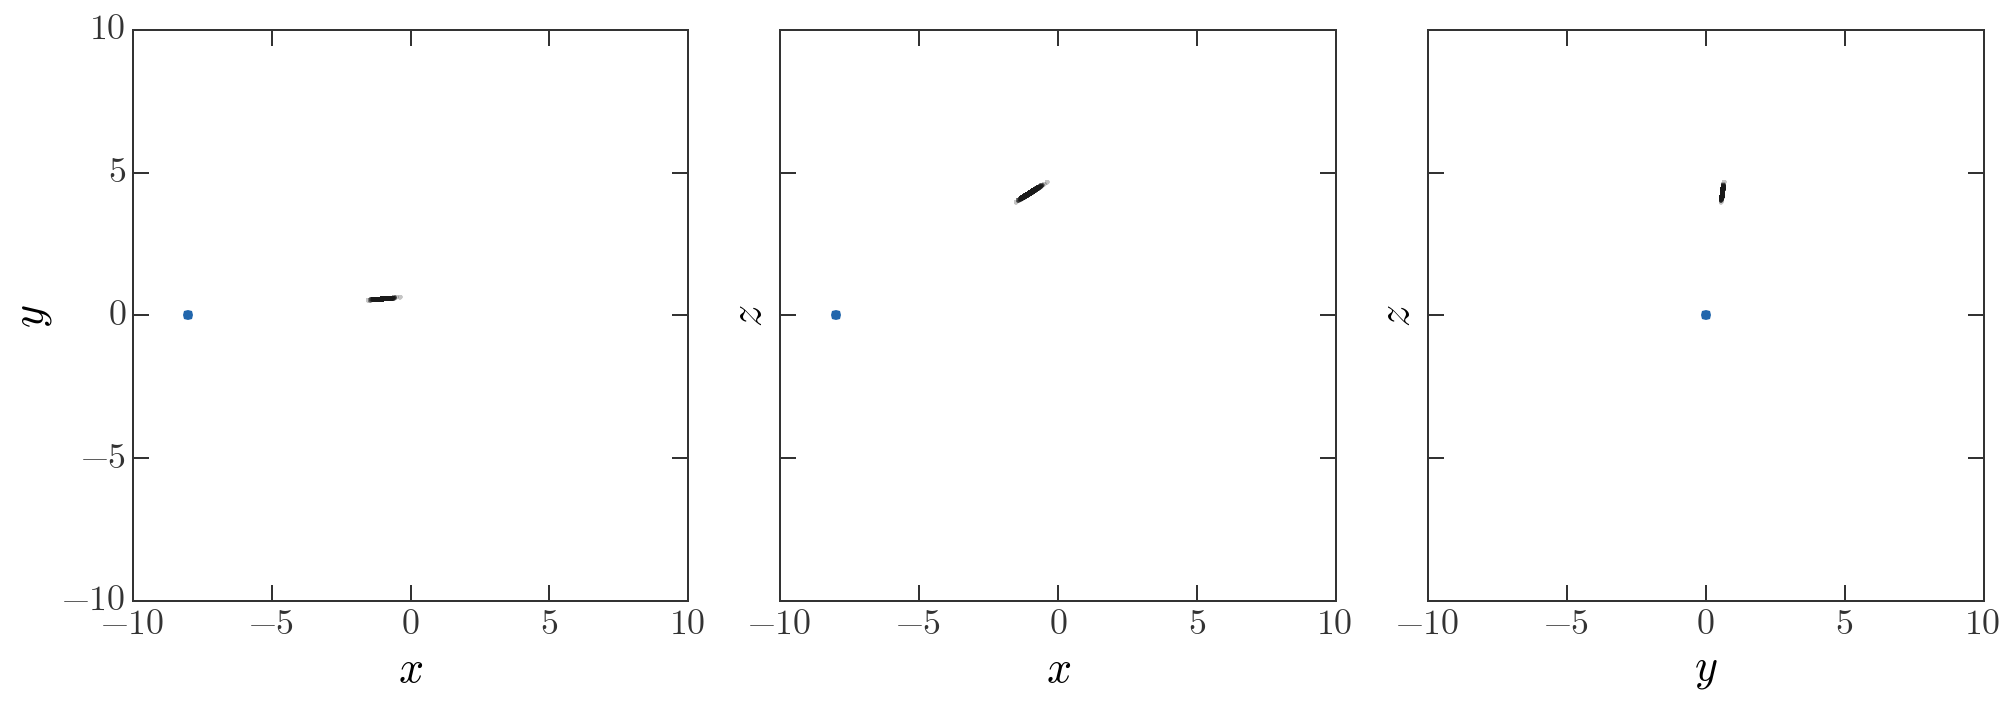

In [7]:
fig = gd.plot_orbits(gc_pos.cartesian.xyz.decompose(galactic).value.T,
                     linestyle='none', marker='.', alpha=0.25)
fig.axes[0].set_xlim(-10,10)
fig.axes[0].set_ylim(-10,10)

sun_xyz = np.array([-8.,0,0])
for i,ax in enumerate(fig.axes):
    ix = np.delete(np.arange(3), 2-i)
    ax.plot(sun_xyz[ix[0]], sun_xyz[ix[1]], marker='o')

### Width 

In [8]:
np.median(((6.*u.arcmin) * d).to(u.pc, equivalencies=u.dimensionless_angles()).value)

14.327482030288238

# Velocity

In [9]:
np.random.seed(42)
mul = -5.6 * u.mas/u.yr
sigma_mul = 2. * u.mas/u.yr
mub = 2.3 * u.mas/u.yr
sigma_mub = 1. * u.mas/u.yr

vlos = 289.1 * u.km/u.s

In [10]:
np.std([271, 318, 237, 259])

29.617351333297851

In [11]:
muls = np.random.normal(mul.value, sigma_mul.value, size=xyz.shape[0])*mul.unit
mubs = np.random.normal(mub.value, sigma_mub.value, size=xyz.shape[0])*mub.unit
vloss = np.random.normal(vlos.value, 0.4, size=xyz.shape[0])*vlos.unit

vxyz = gc.vhel_to_gal(pos, (muls,mubs), vloss, vcirc=220*u.km/u.s, 
                      vlsr=[-11.1,24.,7.25]*u.km/u.s).decompose(galactic).value.T

# Initial conditions

In [12]:
all_w0 = np.hstack((xyz,vxyz))

In [12]:
# np.save("/Users/adrian/projects/ophiuchus/output/w0.npy", all_w0)

# Energy distribution

In [44]:
barred_E = barred_mw.total_energy(xyz, vxyz)
static_E = static_mw.total_energy(xyz, vxyz)

In [45]:
print(np.std(barred_E) / np.mean(barred_E) * -100.)
print(np.std(static_E) / np.mean(static_E) * -100.)

4.15267955768
4.07604273551


# Integrate some orbits

In [42]:
import superfreq as sf
import streammorphology as sm

In [16]:
w0 = all_w0[1]
# w0 = [0,20.,0.,0.2,-0.015,0.01] # test orbit

In [17]:
barred_t,barred_w = barred_mw.integrate_orbit(w0, dt=-0.5, nsteps=12000)
static_t,static_w = static_mw.integrate_orbit(w0, dt=-0.5, nsteps=12000)

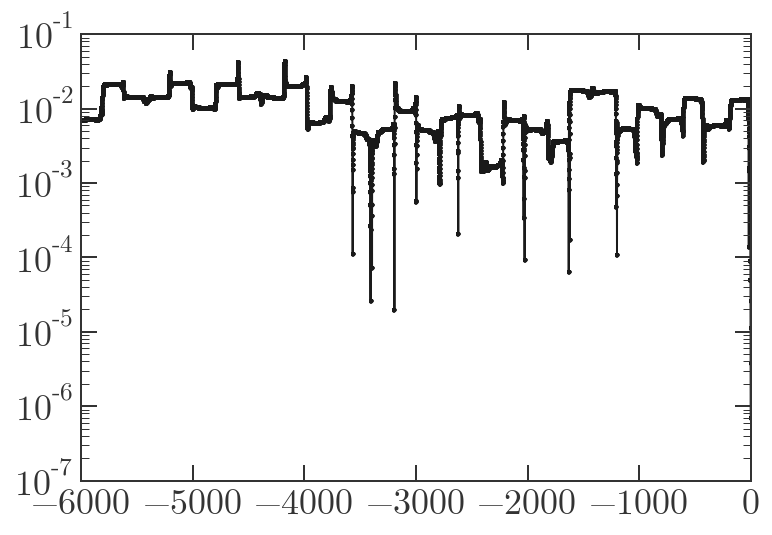

In [22]:
EEE = barred_mw.total_energy(barred_w[:,0,:3],barred_w[:,0,3:])
pl.semilogy(barred_t[1:], np.abs((EEE[1:] - EEE[0])/EEE[0]))

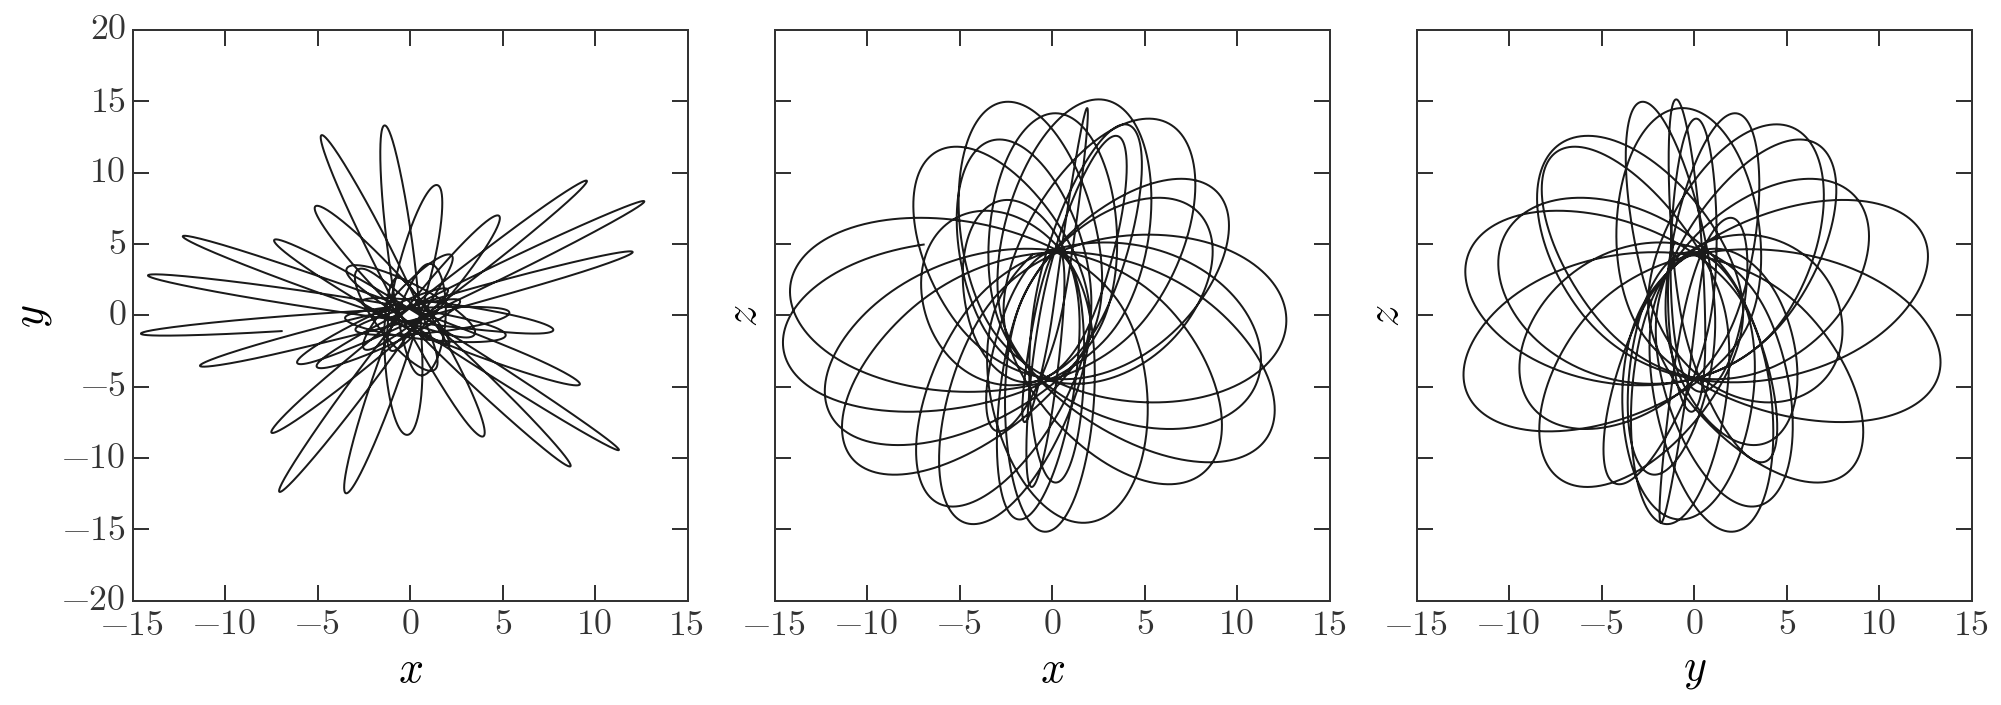

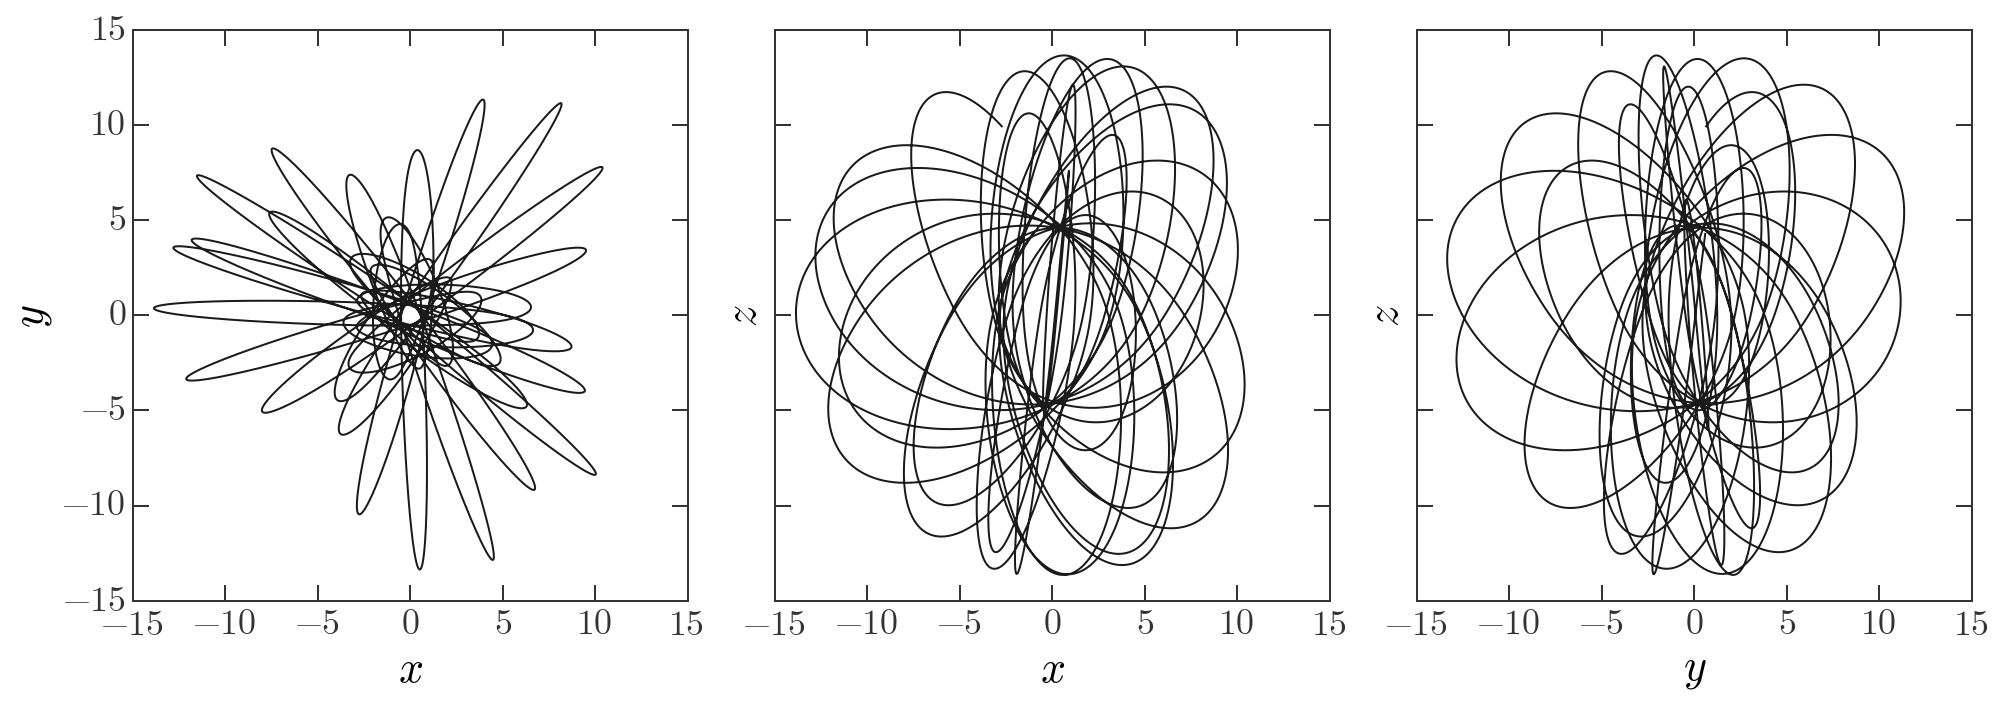

In [18]:
fig = gd.plot_orbits(barred_w[:,0], marker=None)
fig = gd.plot_orbits(static_w[:,0], marker=None)

In [ ]:
nsteps_per_period = 256
nperiods = 256

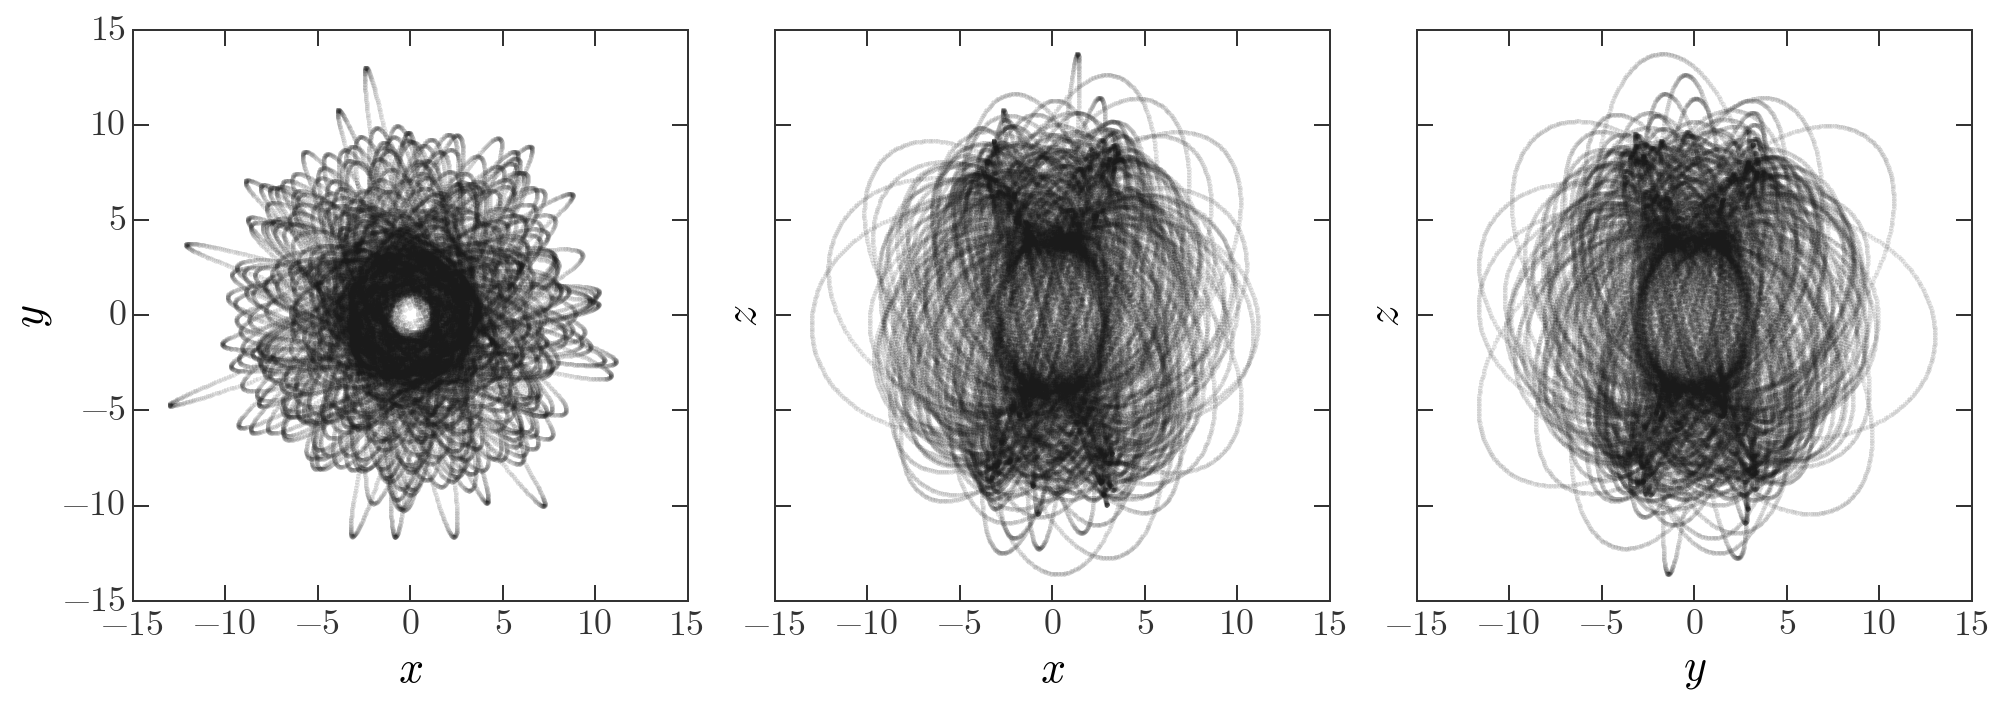

In [62]:
T = gd.peak_to_peak_period(barred_t, barred_w[:,0,0])
dt = T / nsteps_per_period
nsteps = nsteps_per_period * nperiods

barred_t_long,barred_w_long = barred_mw.integrate_orbit(w0, dt=dt, nsteps=nsteps, Integrator=gi.DOPRI853Integrator)
fig = gd.plot_orbits(barred_w_long[:,0], marker='.', ls='none', alpha=0.1)

In [57]:
t = barred_t_long
w = barred_w_long
freqs1,tbl1,ixes1,istube1 = sf.find_frequencies(np.abs(t[:len(t)//2]), w[:len(t)//2,0])
freqs2,tbl2,ixes2,istube2 = sf.find_frequencies(np.abs(t[len(t)//2:]), w[len(t)//2:,0])

np.abs((freqs2 - freqs1)/freqs1)

array([ 0.08262755,  0.08110123,  0.08587253])

---

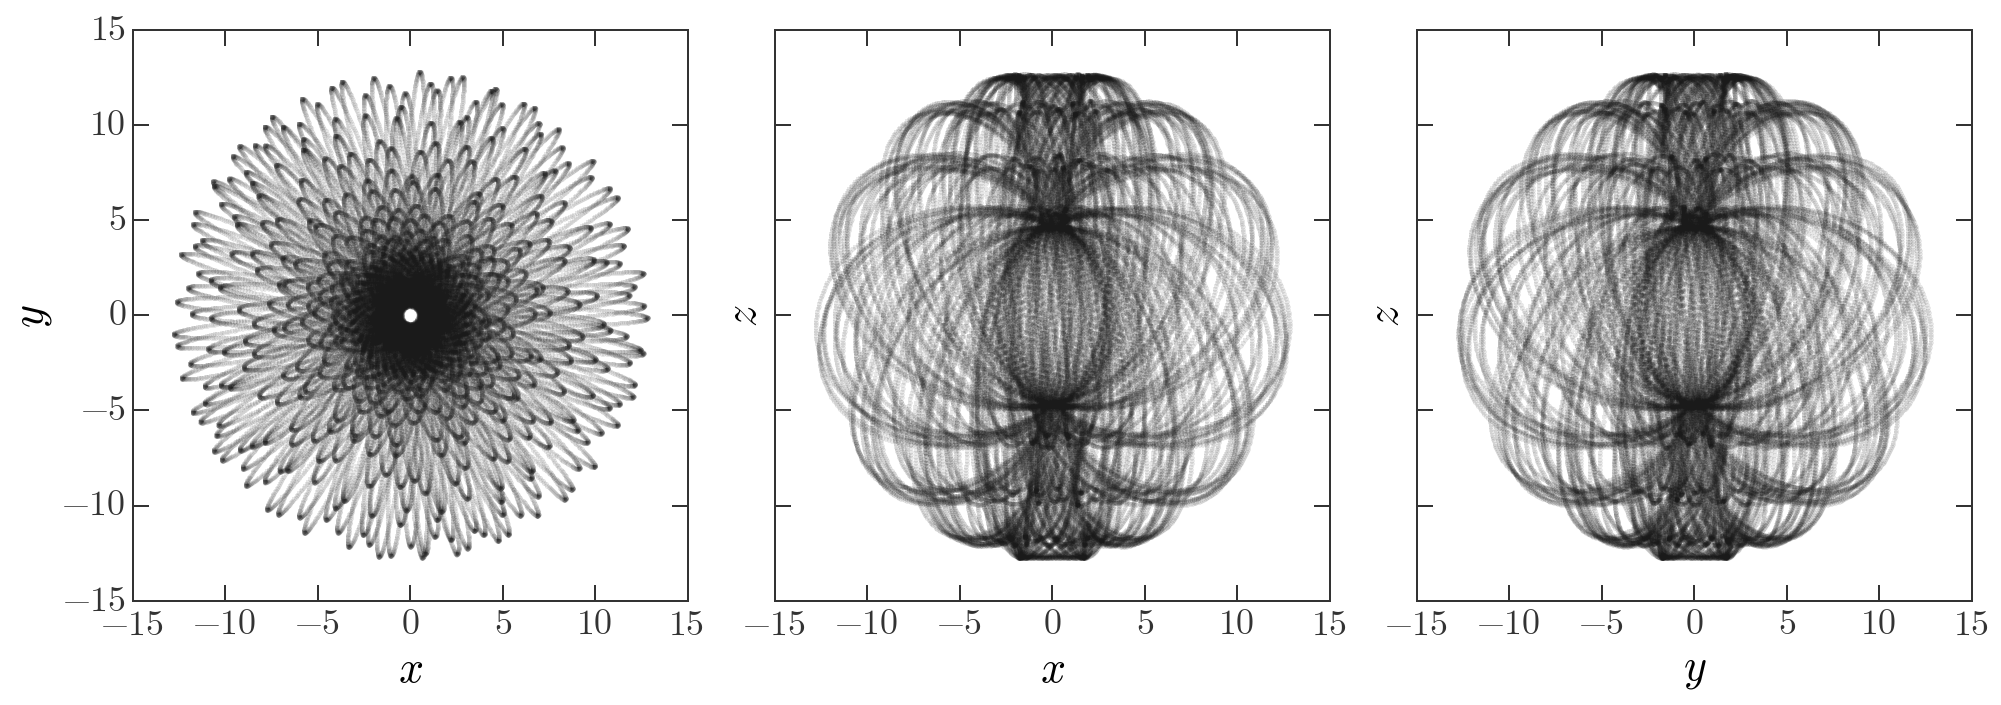

In [61]:
T = gd.peak_to_peak_period(static_t, static_w[:,0,0])
dt = T / nsteps_per_period
nsteps = nsteps_per_period * nperiods

static_t_long,static_w_long = static_mw.integrate_orbit(w0, dt=dt, nsteps=nsteps, Integrator=gi.DOPRI853Integrator)
fig = gd.plot_orbits(static_w_long[:,0], marker='.', ls='none', alpha=0.1)

In [60]:
t = static_t_long
w = static_w_long
freqs1,tbl1,ixes1,istube1 = sf.find_frequencies(np.abs(t[:len(t)//2]), w[:len(t)//2,0])
freqs2,tbl2,ixes2,istube2 = sf.find_frequencies(np.abs(t[len(t)//2:]), w[len(t)//2:,0])

np.abs((freqs2 - freqs1)/freqs1)

array([  1.06393562e-06,   9.35568089e-07,   9.41186064e-07])